## Introduction to Data Science

### Data Science Tasks: Churn Detection

Based on [this](https://medium.com/@hugomichaelisss/predict-customer-churn-using-machine-learning-d120cde1f0e9) blog post and [Github repo](https://github.com/hmssantos/predict-churn/blob/main/Project_01_(Udacity)%20(1).ipynb).  
Full version of data can be found [here](https://www.kaggle.com/sakshigoyal7/credit-card-customers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline

Reading Data

In [2]:
baseChurn = pd.read_csv('../Data/CSV/BankChurners.csv')

In [3]:
baseChurn.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
baseChurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

The central idea here is to understand as much of the dataset as possible. This understanding is not limited to the data itself, but to issues such as its type, whether there are missing values in a given column, whether any specific treatment will be needed, among several other particularities that the dataset can bring with it.

Then I removed the last two variables, as suggested by the database owner.

In [5]:
baseChurn = baseChurn.iloc[:,:-2]

In [6]:
baseChurn = baseChurn.rename(columns={'CLIENTNUM':'customerID'})

With the data initially approved, I proceeded with the interpretation of the numerical variables. To do this, I created an iteration of violin plots to visualize the distribution of data between propensity to churn or not.

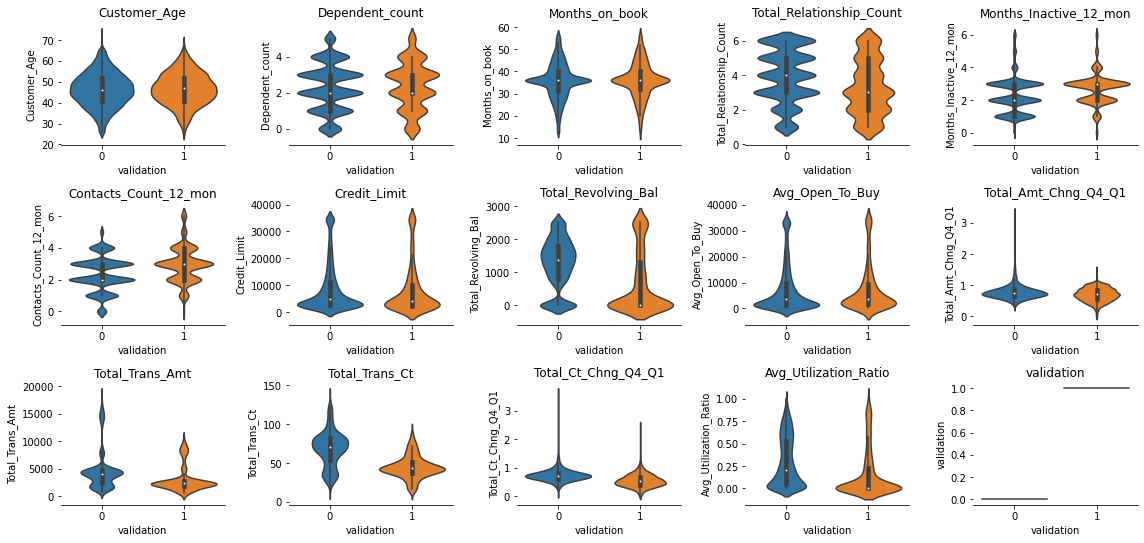

In [7]:
histogram = baseChurn.copy()
del histogram['customerID']

histogram['validation'] = 0
histogram.loc[histogram.Attrition_Flag == 'Existing Customer', 'validation'] = 0
histogram.loc[histogram.Attrition_Flag == 'Attrited Customer', 'validation'] = 1 # Churn

del histogram['Attrition_Flag']

histogram_backup = histogram.copy()
histogram_backup['Attrition_Flag'] = baseChurn['Attrition_Flag']

histogram = histogram.select_dtypes(['number'])
fig = plt.figure(figsize=(16,16)) # Figure size to plot

for i in range(histogram.shape[1]):
    plt.subplot(6, 5, i + 1)
    f = plt.gca()
    f.set_title(histogram.columns.values[i])
    sns.violinplot(data=histogram, x='validation', 

y = histogram.columns[i])
    sns.despine(left=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

I did the same for categorical variables, but instead of using violin plots I used traditional bar charts.

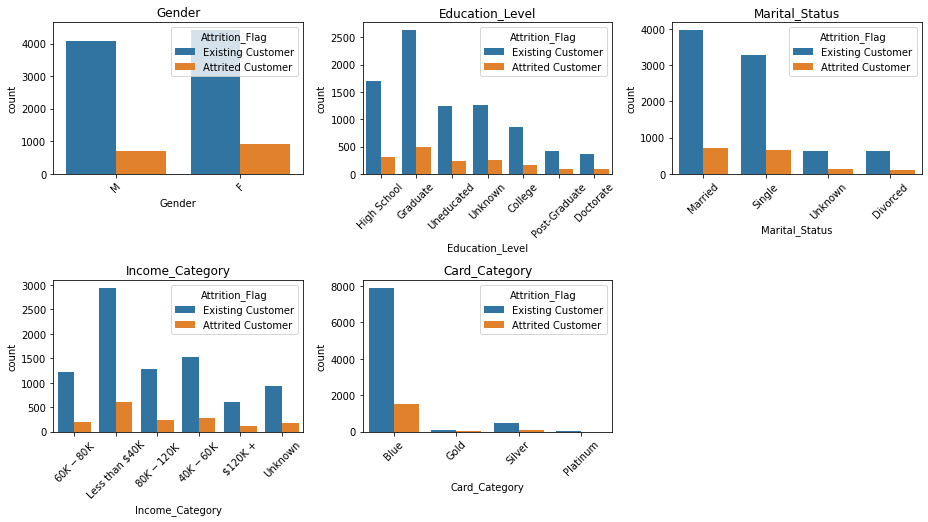

In [8]:
categVariables = baseChurn.copy()
categVariables = categVariables.select_dtypes(['object'])
categVariables['customerID'] = baseChurn['customerID']
c=1
fig = plt.figure(figsize=(13,8)) # Figure size to plot

for i in categVariables:
    if (i != 'Attrition_Flag' and i != 'customerID'):
        plt.subplot(2, 3, c)
        plotCategVar = pd.DataFrame()
        plotCategVar = baseChurn[['customerID','Attrition_Flag',i]]
        f = plt.gca()
        f.set_title(i)
        sns.countplot(data=plotCategVar, x = i, hue = 'Attrition_Flag')
        plt.xticks(rotation=45)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        c += 1

Finally, I explored the correlation between numerical variables.

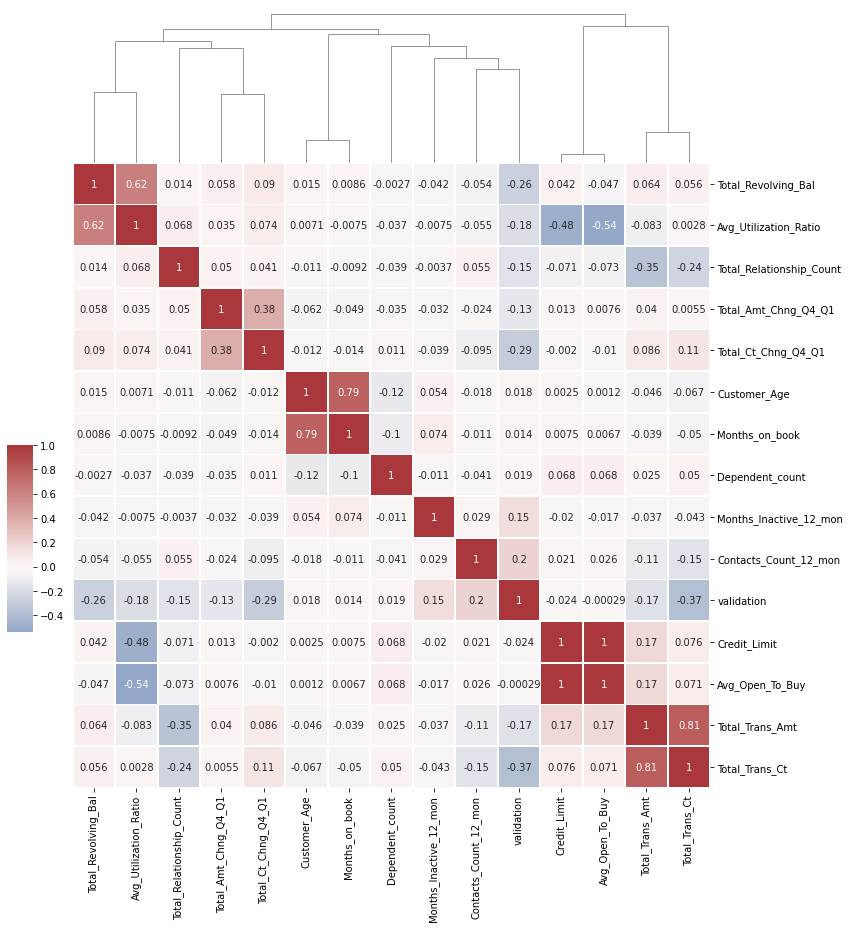

In [9]:
corrMatrix = histogram
g = sns.clustermap(corrMatrix.corr(), 
                   center=0, 
                   cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, 
                   figsize=(12, 13), 
                   annot=True)

g.ax_row_dendrogram.remove()

### Data Preparation

Well, at this point in the championship, if I ask you if there is any distortion between the representation of genders in the base, if there are more clients with a doctorate or high school, or which variable has the lowest correlation with the validation variable you probably already know how to tell me.

Now, the intention is to prepare the data. Starting with multicollinearity. If you want to put yourself briefly in context, I suggest you to read this quick article.

Below, I create a function to identify the multicollinearity of variables that exist in a given dataset and apply it to the dataset.

In [10]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

analysisVIF = baseChurn.select_dtypes(['number']).drop(columns=['customerID'])
calc_vif(analysisVIF).sort_values(by='VIF', ascending=False).head(5)

/home/rsouza/environments/default_env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
6,Credit_Limit,inf
7,Total_Revolving_Bal,inf
8,Avg_Open_To_Buy,inf
0,Customer_Age,75.090540
2,Months_on_book,56.437261


A very high multicollinearity is perceived for certain variables.

It may be that you, when first saw the cluster map, had noticed something strange. In case you didn’t notice, come back to it before we continue.

Note that there are high correlations between variables, on the diagonal axis that starts in the upper left corner and ends in the lower right corner.

Let’s take a closer look at this. I plotted the variables with the greatest multicollinearity along with the variables with the greatest correlation.

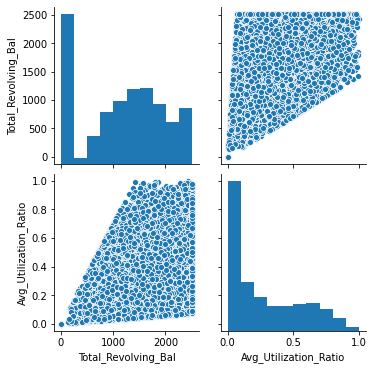

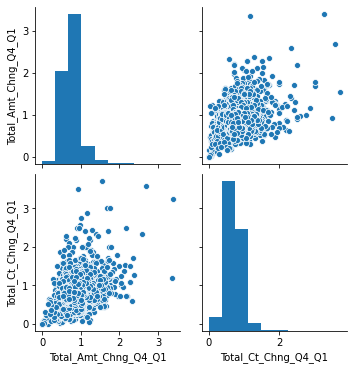

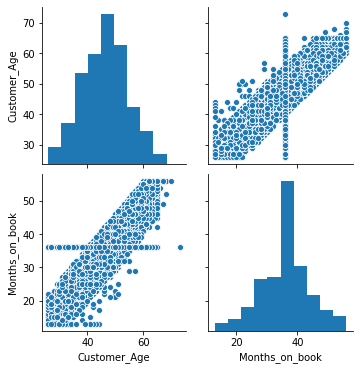

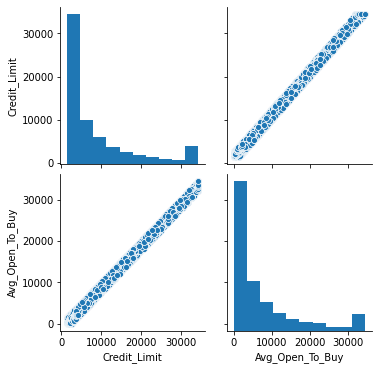

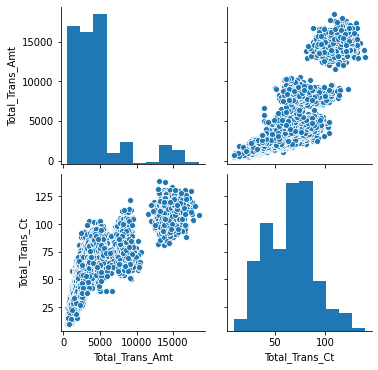

In [12]:
groupColumns = [['Total_Revolving_Bal','Avg_Utilization_Ratio'],
                ['Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1'],
                ['Customer_Age','Months_on_book'],
                ['Credit_Limit','Avg_Open_To_Buy'],
                ['Total_Trans_Amt','Total_Trans_Ct']]


for group in groupColumns:
    sns.pairplot(analysisVIF[group])
    
plt.show()

The strong correlation between the variables is evident in all the graphs above, although some more than others. The most obvious example is regarding the correlation between the variable ‘Credit_Limit’ and the ‘Avg_Open_To_Buy’ (the fourth graph from left to right). In the cluster map itself, it is possible to verify the correlation between both equal to 1.

Well, once the variables that have greater multicollinearity are identified, I need to remove them so as not to compromise future statistical inferences. Below is the deletion of the variables that I opted for and the new measurement of multicollinearity.

In [13]:
del analysisVIF['Avg_Utilization_Ratio']
del analysisVIF['Total_Ct_Chng_Q4_Q1']
del analysisVIF['Months_on_book']
del analysisVIF['Avg_Open_To_Buy']
del analysisVIF['Total_Trans_Ct']

calc_vif(analysisVIF).sort_values(by='VIF', ascending=False).head(5)

,variables,VIF
0,Customer_Age,17.720704
7,Total_Amt_Chng_Q4_Q1,10.952239
2,Total_Relationship_Count,7.115694
3,Months_Inactive_12_mon,6.031580
4,Contacts_Count_12_mon,5.532626


I plotted the cluster map again to exclude any possibility of residual problem.

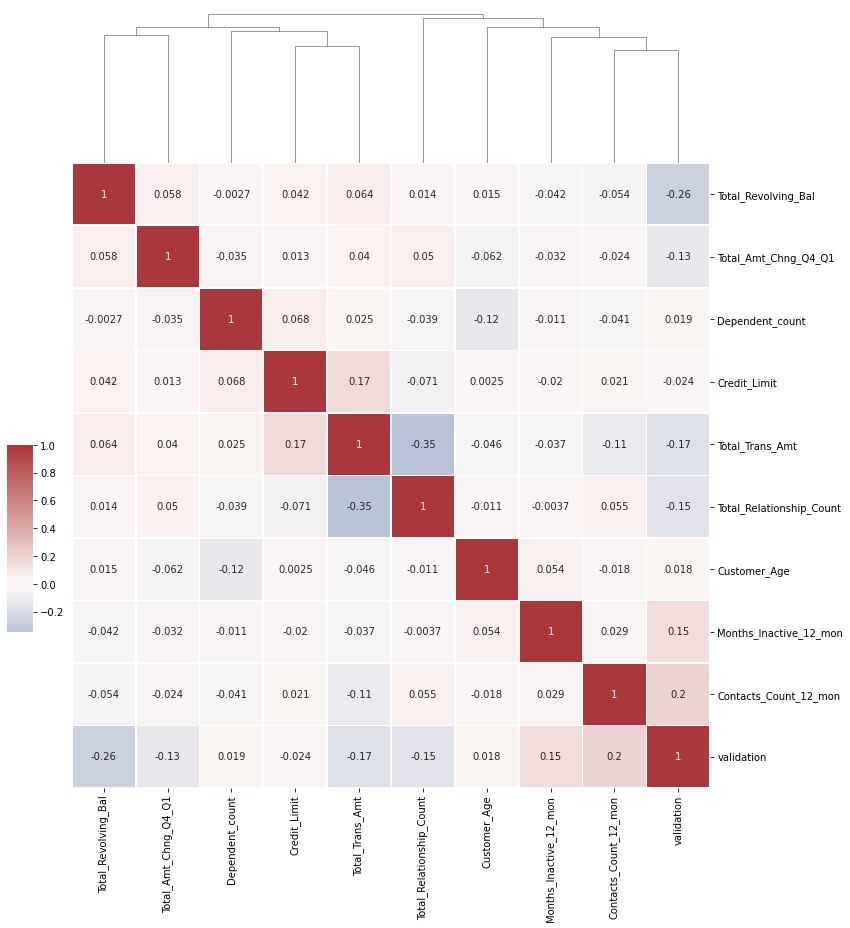

In [14]:
# Another check of the correlation between variables after preparation 

corrMatrix = histogram

del corrMatrix['Avg_Utilization_Ratio']
del corrMatrix['Total_Ct_Chng_Q4_Q1']
del corrMatrix['Months_on_book']
del corrMatrix['Avg_Open_To_Buy']
del corrMatrix['Total_Trans_Ct']

g = sns.clustermap(corrMatrix.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13), annot=True)

g.ax_row_dendrogram.remove()

### Analysis / Modeling

We arrived at the most expected part. Now, with the base ready, let’s start analyzing the data and implementing machine learning.

To start this part effectively, I removed the fields I’d already justified the reason why in the previous moment, as well as recreate the churn variable, based on the original variable ‘Attrition_Flag’.

Afterwards, I created the identity matrix and removed the variable from the base.

In [15]:
# I start here the steps related to the preparation of the data for the statistical modeling

baseChurn['Churn'] = 0

baseChurn.loc[baseChurn.Attrition_Flag == 'Existing Customer', 'Churn'] = 0
baseChurn.loc[baseChurn.Attrition_Flag == 'Attrited Customer', 'Churn'] = 1 # Churn

del baseChurn['Attrition_Flag']
del baseChurn['Avg_Utilization_Ratio']
del baseChurn['Total_Ct_Chng_Q4_Q1']
del baseChurn['Months_on_book']
del baseChurn['Avg_Open_To_Buy']
del baseChurn['Total_Trans_Ct']

identity = baseChurn['customerID']
baseChurn = baseChurn.drop(columns='customerID')

# I use the get dummies here to convert categorical variable into indicator variables

baseChurn= pd.get_dummies(baseChurn)
baseChurn = pd.concat([baseChurn, identity], axis = 1)

In [16]:
# I separate the target variable from the rest of the dataset

target = baseChurn['Churn']
baseChurn = baseChurn.drop(columns='Churn')

In [17]:
# Here, the dataset is divided between training and test according to the parameters used

X_train, X_test, y_train, y_test = train_test_split(baseChurn, target, stratify=target, test_size = 0.2, random_state = 0)
train_identity = X_train['customerID']
X_train = X_train.drop(columns = ['customerID'])
test_identity = X_test['customerID']
X_test = X_test.drop(columns = ['customerID'])

In [18]:
# Normalization of the dataset

sc_X = StandardScaler()

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

### Evaluation

In this part of the article, I focus on the efficiency of the model for its purpose, which is to identify where the churn is and develop a strategy to combat it.

The model I chose was the logistic regression.

Below I submit it to my training dataset and calculate its accuracy along with its standard deviation.

In this section I answer the questions that were proposed in Section 2 (Data Understanding). After answering these questions I continue to build the model.

+ Question 1: Which customer education level is most likely to Churn?
+ Question 2: What is the median total transaction value of customers who churn?

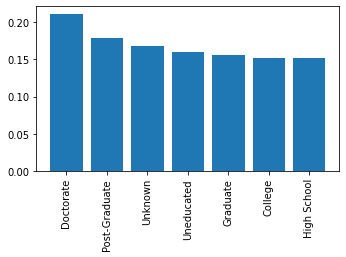

In [19]:
fig = plt.figure(figsize=(5,4))

plotCategVar = pd.DataFrame()
plotCategVar = categVariables[['customerID','Attrition_Flag','Education_Level']]
plotCategVar = pd.crosstab(plotCategVar['Education_Level'],
                           plotCategVar['Attrition_Flag']).apply(lambda r: r/r.sum(), axis=1)
plotCategVar = plotCategVar.reset_index(drop=False).sort_values(by='Attrited Customer',ascending=False)

plt.bar(plotCategVar['Education_Level'],plotCategVar['Attrited Customer'])
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Median Total Transaction: 2329.00


<Figure size 360x288 with 0 Axes>

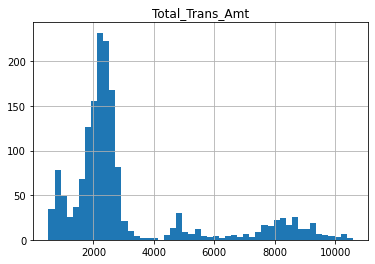

In [21]:
fig = plt.figure(figsize=(5,4))

histogram_backup[histogram_backup['Attrition_Flag']=='Attrited Customer'].hist('Total_Trans_Amt', bins=50)

print('Median Total Transaction: {0:.2f}'.format(histogram_backup['Total_Trans_Amt'][histogram_backup['Attrition_Flag']=='Attrited Customer'].median()))

In [23]:
max_corr = histogram_backup.corr().abs()
max_corr = max_corr.unstack()
max_corr = max_corr.sort_values(kind="quicksort", ascending=False)
max_corr = max_corr.reset_index(drop=False)
max_corr[max_corr['level_0'] != max_corr['level_1']].sort_values(by=0, ascending=False).iloc[0]

level_0    Avg_Open_To_Buy
level_1       Credit_Limit
0                 0.995981
Name: 15, dtype: object

In [24]:
# I chose to use logistic regression because I understand this kind of model is useful in this situation

classifier = LogisticRegression(random_state = 0, penalty = 'l2')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracies = cross_val_score(estimator = classifier,X = X_train, y = y_train, cv = 10)
print("Logistic Regression Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(),
accuracies.std()*2))

Logistic Regression Classifier Accuracy: 0.87 (+/- 0.01)


The result obtained was approximately 87% accuracy with a standard deviation of +/- 1% which is very satisfactory.

To confirm the efficiency of the model I evaluate it using the ROC curve.

Text(0.5, 15.0, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

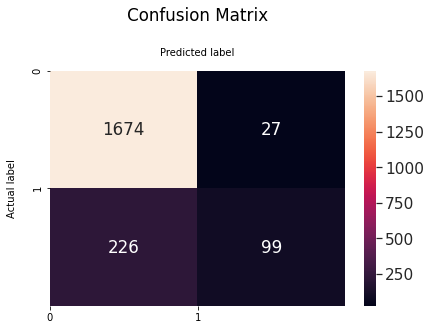

In [25]:
# Creating a Confusion Matrix

cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion Matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

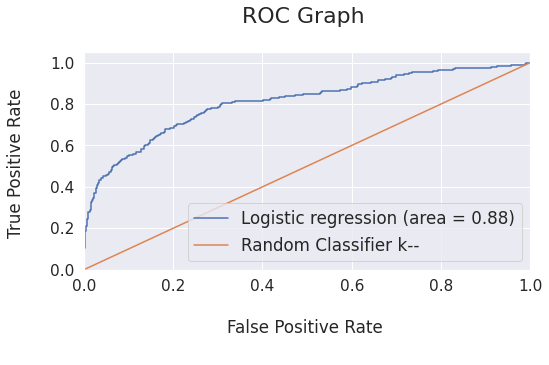

In [26]:
# Evaluating the model using ROC Graph

classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 4))

plt.plot(rf_fpr, rf_tpr, 
label='Logistic regression (area = %0.2f)' % classifier_roc_auc)

plt.plot([0,1], [0,1],label='Random Classifier ' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

plt.show()

The orange line represents the ROC curve of a random classifier. A good classifier tries to stay as far away from that line as possible. As can be seen, the model performed well.

Once the good performance of the model has been validated, let’s see the feature importances.

In [27]:
# Creating a table with the feature importances

feature_importances = pd.concat([
pd.DataFrame(baseChurn.drop(columns='customerID').
columns, columns = ['variables']),
pd.DataFrame(np.transpose(classifier.coef_), 
columns = ["coef"])],axis = 1)
featImport = feature_importances.sort_values("coef", ascending = False)

The variable that most influences the Churn probability is: Total_Trans_Amt 



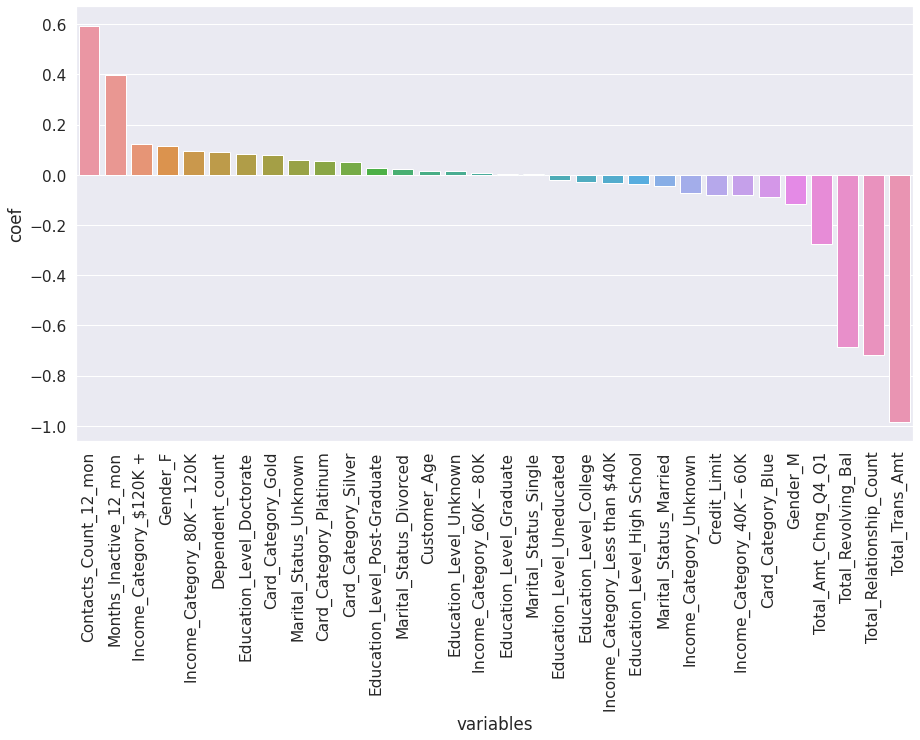

In [28]:
fig = plt.figure(figsize=(15, 8))

t = sns.barplot(x=featImport.iloc[:,0], y=featImport.iloc[:,1])
plt.xticks(rotation=90)

varAnswer = featImport['variables'][featImport.iloc[:,1].abs() == featImport.iloc[:,1].abs().max()]

print('The variable that most influences the Churn probability is: {} \n'.format(varAnswer.iloc[0]))

It is quite evident which are the variables that most potentiate Churn, whether due to a high positive or negative correlation.

To finalize the practical purpose model implementation, let’s go to the grand finale: the implementation of tuning techniques to reduce model overfit.

When training a model, the model must find a weight for each feature.

Each weight is a value in vector theta.

Considering there is a penalty on having a weight for a feature, this encourages the model to move the weights closer to zero for some features.

Therefore, a regularization minimizes the complexity of a model to avoid overfitting.

In [29]:
# I apply adjusting techniques in order to reduce the overfit of the model

# When training a model, the model must find a weight for each feature.
# Each weight is a value in the theta vector. As there is now a penalty on 
# having a weight for a feature, this encourages the model to move 
# the weights closer to 0 for some features.
# Therefore, a regularization minimizes the complexity of a model to avoid overfitting.

# First try:

penalty = ['l1', 'l2'] 

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)

lr_classifier  = lr_classifier .fit(X_train, y_train)
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

/home/rsouza/environments/default_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rsouza/environments/default_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rsouza/environments/default_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/rsouza/environments/default_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The sco

(0.6575825285438619, {'C': 10, 'penalty': 'l2'})

In other words, the most efficient penalty was the l2.

As I could see that the l2 was the best penalty, I applied it to the model and submitted it to the test base.

In [30]:
# Second try:

penalty = ['l2']

C = [ 0.0001, 0.001, 0.01, 0.02, 0.05]

parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)
lr_classifier  = lr_classifier .fit(X_train, y_train)
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

(0.6531259474326867, {'C': 0.05, 'penalty': 'l2'})

In [31]:
# I could visualize the l2 was the best hyperparameter

lr_classifier = LogisticRegression(random_state = 0, penalty = 'l2')
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

# Score of the probabilities
y_pred_probs = lr_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

### Results

And finally, we reach the last step.

I check the predictions made by the model for each of the customers.

In [32]:
# Here I predict the churn probability for each customer

final_results = pd.concat([test_identity, y_test], axis = 1).dropna()
final_results['predictions'] = y_pred
final_results['probChurn'] = y_pred_probs
final_results['probChurn'] = final_results['probChurn']*100
final_results['probChurn']=final_results['probChurn'].round(2)
final_results = final_results[['customerID', 'Churn', 'predictions', 'probChurn']]
final_results ['Ranking'] = pd.qcut(final_results['probChurn'].rank(method = 'first'),10,labels=range(10,0,-1))
print(final_results.sort_values(by='probChurn', ascending=False))

      customerID  Churn  predictions  probChurn Ranking
4184   803796708      1            1      96.27       1
3788   713730933      1            1      93.60       1
3983   708834483      1            1      91.76       1
3718   719770158      1            1      89.38       1
5925   809849358      1            1      88.76       1
...          ...    ...          ...        ...     ...
9835   716151858      0            0       0.10      10
9825   721438233      0            0       0.09      10
9841   715601808      0            0       0.08      10
9814   718805733      0            0       0.08      10
9819   716894658      0            0       0.07      10

[2026 rows x 5 columns]


See above, that in the column ‘probChurn’ it is possible to observe the probability of a certain customer to churn.

With this information, as well as the proper mapping of the main offenders in hand, it is possible to unlock campaigns that seek to retain such customers, whether they are oriented to the individual in a single way or as a group.

Finally, as expected, most customers tend to remain loyal and the group with the highest probability of churn is less representative.

(array([1111.,  397.,  199.,  100.,   79.,   49.,   36.,   25.,   20.,
          10.]),
 array([7.000e-02, 9.690e+00, 1.931e+01, 2.893e+01, 3.855e+01, 4.817e+01,
        5.779e+01, 6.741e+01, 7.703e+01, 8.665e+01, 9.627e+01]),
 <BarContainer object of 10 artists>)

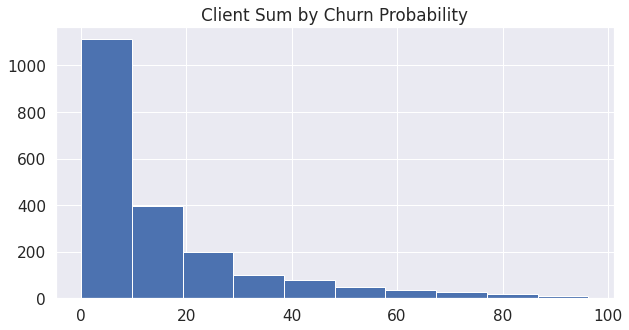

In [33]:
# And here I end my presentation with a graph that contains the above data
fig = plt.figure(figsize=(10,5))
plt.title('Client Sum by Churn Probability')
plt.hist(x=final_results['probChurn'], bins=10)

In [34]:
final_results.loc[final_results.probChurn <= 100, 'Range'] = '90-100'
final_results.loc[final_results.probChurn <= 90, 'Range']  = '80-90'
final_results.loc[final_results.probChurn <= 80, 'Range']  = '70-80'
final_results.loc[final_results.probChurn <= 70, 'Range']  = '60-70'
final_results.loc[final_results.probChurn <= 60, 'Range']  = '50-60'
final_results.loc[final_results.probChurn <= 50, 'Range']  = '40-50'
final_results.loc[final_results.probChurn <= 40, 'Range']  = '30-40'
final_results.loc[final_results.probChurn <= 30, 'Range']  = '20-30'
final_results.loc[final_results.probChurn <= 20, 'Range']  = '10-20'
final_results.loc[final_results.probChurn <= 10, 'Range']  = '0-10'

final_results = final_results.groupby(['Range'])['customerID'].count()

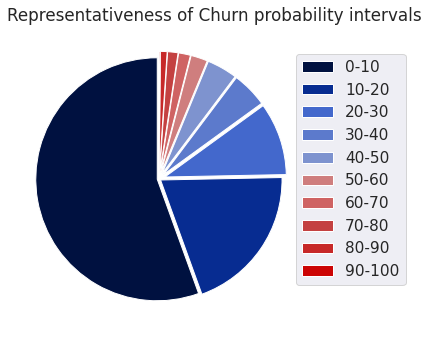

In [35]:
fig1, ax1 = plt.subplots(figsize=(10, 5))

explode = (0.015, 0.015, 0.05, 0.05, 0.05,
           0.05, 0.05, 0.05, 0.05, 0.05)
colors = ['#001140','#072c91','#4368cc','#5c7acc','#7e93cf',
          '#cf7e7e','#cf6363','#c44141','#c72828','#cc0404']

ax1.pie(final_results.tolist(), explode=explode, startangle=90, colors=colors)

ax1.legend(final_results.index.tolist(), loc=(0.95, 0.15))
ax1.set_title('Representativeness of Churn probability intervals', loc='left')
plt.tight_layout()
plt.show()